# Clustering

### Ehsan Farahbakhsh

*EarthByte Group, School of Geosciences, University of Sydney, NSW 2006, Australia*

In this notebook, we load the Indian Pines hyperspectral dataset, apply principal component analysis, and then use the k-means algorithm to generate a clustered map. The results are evaluated using different performance metrics, e.g., Silhouette Score.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.cluster.hierarchy as shc
from scipy.io import loadmat
from time import time

from sklearn import cluster
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score, rand_score, adjusted_rand_score
from sklearn.metrics import mutual_info_score, adjusted_mutual_info_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import minmax_scale

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

In [2]:
# Import the data
data_array = loadmat('./Data/Indian_pines/Indian_pines_corrected.mat')['indian_pines_corrected'] # Hyperspectral data
gt = loadmat('./Data/Indian_pines/Indian_pines_gt.mat')['indian_pines_gt'] # Ground truth data

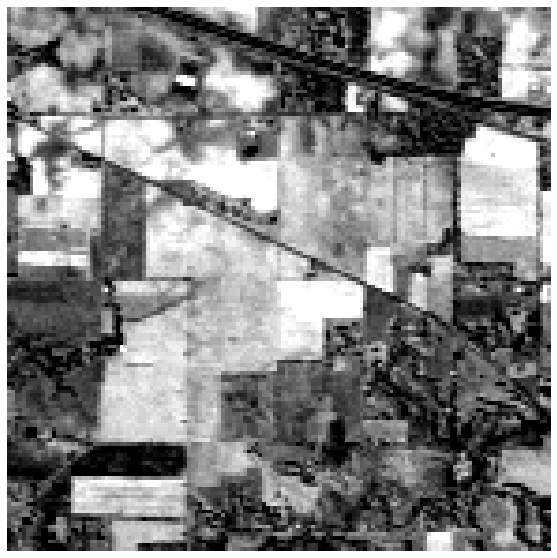

In [3]:
# Visualize
# Read and enhance
vmin, vmax = np.nanpercentile(data_array[:, :, 100], (5, 95)) # 5-95% pixel values stretch
# Plot the enhanced image of a spectral band
fig = plt.figure(figsize=[15, 10])
plt.axis('off')
plt.imshow(data_array[:, :, 100], cmap='gray', vmin=vmin, vmax=vmax)
plt.show()

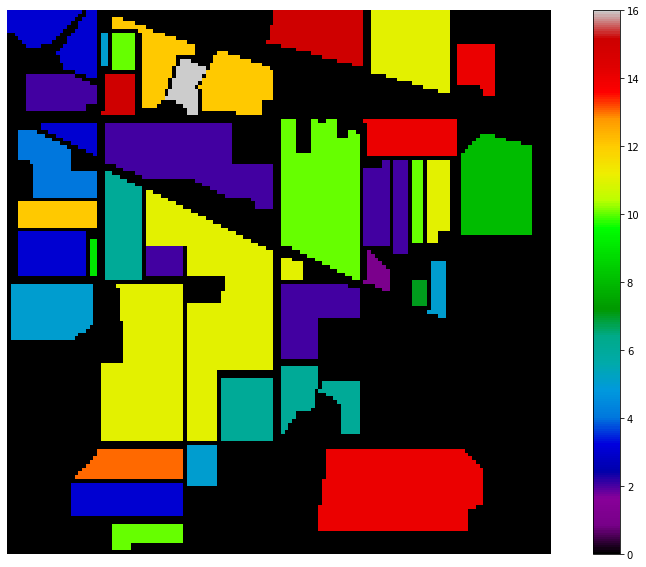

In [4]:
# Plot the gt
def plot_data(data):
    fig = plt.figure(figsize = (15, 10))
    plt.imshow(data, cmap = 'nipy_spectral')
    plt.colorbar()
    plt.axis('off')
    plt.show()

plot_data(gt)

In [5]:
# Reshape the input data from rcb to samples and features
data_reshaped = data_array.reshape(data_array.shape[0]*data_array.shape[1], -1)
data_reshaped = minmax_scale(data_reshaped, feature_range=(0, 1), axis=0, copy=False)
gt_reshaped = gt.flatten()

# PCA

In [6]:
# PCA
pca = PCA()
components = pca.fit_transform(data_reshaped)
# eigenvectors = pca.components_
eigenvalues = pca.explained_variance_
var_ratio = pca.explained_variance_ratio_

var_sum = 0
for i in range(len(var_ratio)):
    if var_sum >= 0.99:
        break
    else:
        var_sum += var_ratio[i]

selected_components = components[:, :i]
print('Number of spectral bands:', data_reshaped.shape[1])
print(f'Number of selected principal components: {i}')

Number of spectral bands: 200
Number of selected principal components: 31


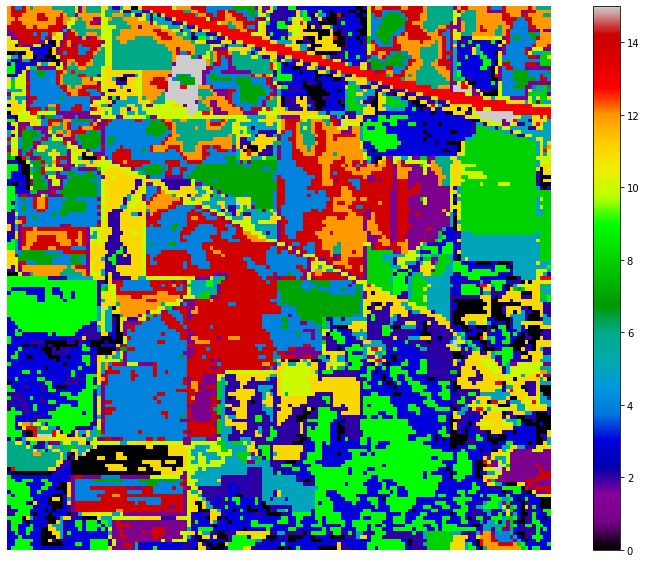

In [7]:
# k-means clustering using selected principal components
cl = cluster.KMeans(n_clusters=16, random_state=1) # Create an object of the classifier
param = cl.fit_predict(selected_components) # Train
img_cl = cl.labels_ # Get the labels of the classes
img_cl = img_cl.reshape(data_array[:, :, 0].shape) # Reshape the labels to a 3D array (single band)
plot_data(img_cl)

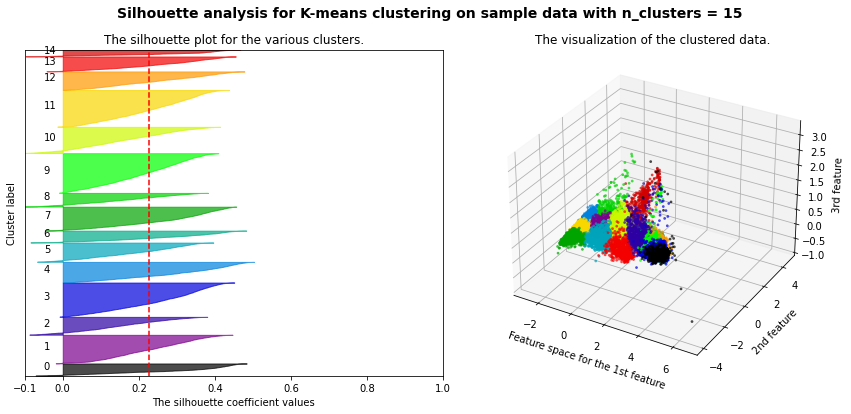

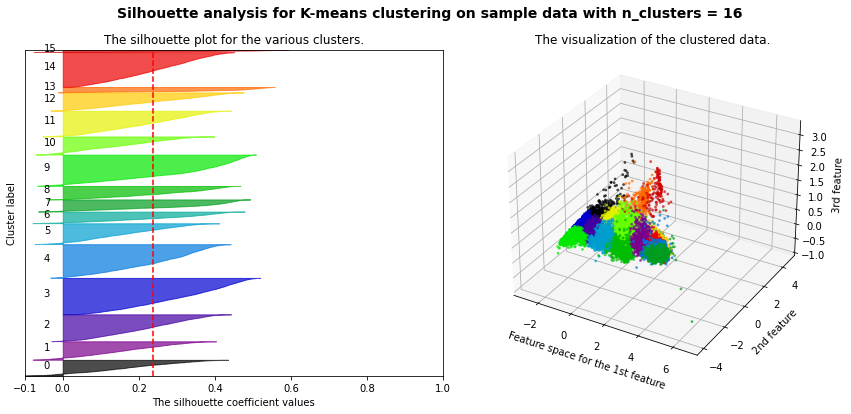

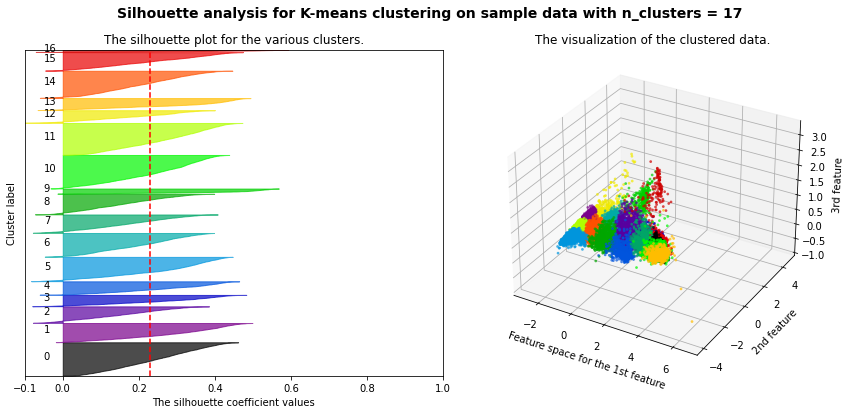

In [8]:
# Calculate different performance metrics for various numbers of clusters
range_n_clusters = list(range(15, 18))
columns = ['Number of clusters', 'Average Silhouette score', 'Rand index', 'Adjusted Rand index', 'Mutual Information score',
           'Adjusted Mutual Information score', 'Calinski-Harabasz score', 'Davies-Bouldin score']
scores_pca = pd.DataFrame(np.zeros((len(range_n_clusters), len(columns))), columns=columns)

# 3D plots and different scores
for count, n_clusters in enumerate(range_n_clusters):
    # Create a subplot with 1 row and 2 columns
    fig = plt.figure(figsize=[15, 6])
    ax1 = fig.add_subplot(1, 2, 1)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(selected_components) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = cluster.KMeans(n_clusters=n_clusters, random_state=1)
    cluster_labels = clusterer.fit_predict(selected_components)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(selected_components, cluster_labels)
    
    scores_temp = [n_clusters, silhouette_avg,
                   # Similarity score between 0.0 and 1.0, inclusive, 1.0 stands for perfect match.
                   rand_score(gt_reshaped, clusterer.labels_),
                   # Similarity score between -1.0 and 1.0. Random labelings have an ARI close to 0.0. 1.0 stands for perfect match.
                   adjusted_rand_score(gt_reshaped, clusterer.labels_),
                   # Mutual information, a non-negative value, measured in nats using the natural logarithm.
                   mutual_info_score(gt_reshaped, clusterer.labels_),
                   # The AMI returns a value of 1 when the two partitions are identical (ie perfectly matched).
                   # Random partitions (independent labellings) have an expected AMI around 0 on average
                   # hence can be negative. The value is in adjusted nats (based on the natural logarithm).
                   adjusted_mutual_info_score(gt_reshaped, clusterer.labels_),
                   # The resulting Calinski-Harabasz score.
                   calinski_harabasz_score(selected_components, clusterer.labels_),
                   # The resulting Davies-Bouldin score.
                   # The minimum score is zero, and the lower values the better clustering performance.
                   davies_bouldin_score(selected_components, clusterer.labels_)]
    
    scores_pca.iloc[[count]] = scores_temp

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(selected_components, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title('The silhouette plot for the various clusters.')
    ax1.set_xlabel('The silhouette coefficient values')
    ax1.set_ylabel('Cluster label')

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color='red', linestyle='--')

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        selected_components[:, 0], selected_components[:, 1], selected_components[:, 2],
        marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k'
    )

    ax2.set_title('The visualization of the clustered data.')
    ax2.set_xlabel('Feature space for the 1st feature')
    ax2.set_ylabel('2nd feature')
    ax2.set_zlabel('3rd feature')

    plt.suptitle(
        'Silhouette analysis for K-means clustering on sample data with n_clusters = %d'
        % n_clusters,
        fontsize=14,
        fontweight='bold',
    )
    
    fig.subplots_adjust(wspace=0, hspace=0)

plt.show()

In [9]:
from IPython.display import display, HTML
display(HTML(scores_pca.to_html(index=False)))

Number of clusters,Average Silhouette score,Rand index,Adjusted Rand index,Mutual Information score,Adjusted Mutual Information score,Calinski-Harabasz score,Davies-Bouldin score
15.0,0.226471,0.695731,0.063490,0.663658,0.297282,15824.581111,1.285484
16.0,0.237419,0.697657,0.067562,0.686664,0.306000,15460.696996,1.204686
17.0,0.228744,0.698171,0.061880,0.694602,0.304355,15156.079941,1.233528


# Elbow method
Two methods are used to plot the elbow graph to determine the optimal number of clusters.

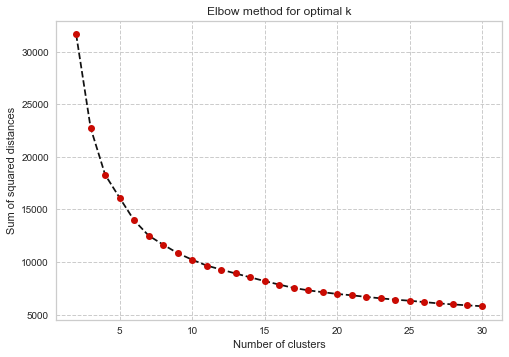

In [10]:
from yellowbrick.cluster import KElbowVisualizer

sum_squared_distance = []
range_n_clusters = range(2, 31)
for k in range_n_clusters:
    clusterer = cluster.KMeans(n_clusters=k, random_state=1)
    clusterer.fit(selected_components)
    sum_squared_distance.append(clusterer.inertia_)
    
plt.plot(range_n_clusters, sum_squared_distance, 'ko--', mfc='r')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow method for optimal k')
plt.grid(linestyle='--')
plt.show()

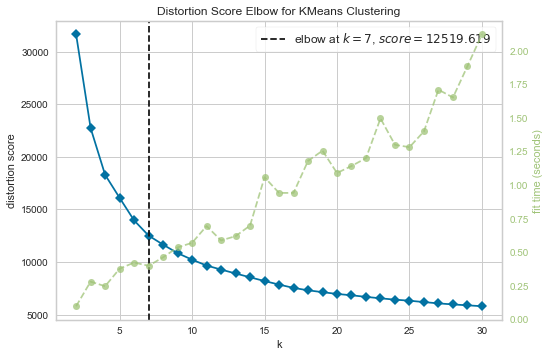

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [11]:
visualizer = KElbowVisualizer(cluster.KMeans(random_state=1), k=(2, 31), timings=True)
# Fit the data
visualizer.fit(selected_components)
# Finalize and render figure
visualizer.show()

# Silhouette score

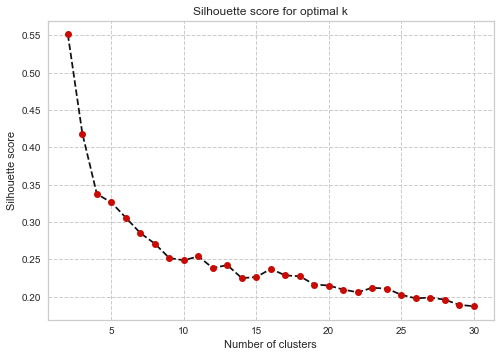

In [12]:
silhouette_avg = []
for k in range_n_clusters:
    clusterer = cluster.KMeans(n_clusters=k, random_state=1)
    clusterer.fit(selected_components)
    cluster_labels = clusterer.labels_
    silhouette_avg.append(silhouette_score(selected_components, cluster_labels))
    
plt.plot(range_n_clusters, silhouette_avg, 'ko--', mfc='r')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette score for optimal k')
plt.grid(linestyle='--')
plt.show()

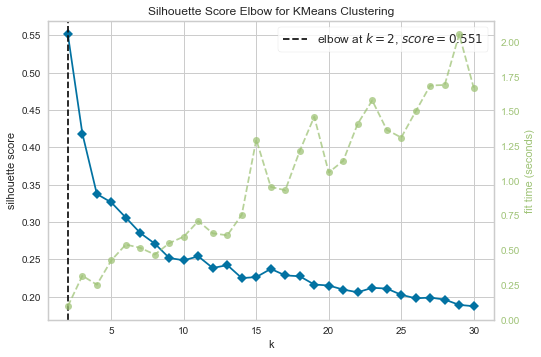

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [13]:
visualizer = KElbowVisualizer(cluster.KMeans(random_state=1), k=(2, 31), metric='silhouette', timings=True)
# Fit the data
visualizer.fit(selected_components)
# Finalize and render figure
visualizer.show()

# Calinski-Harabasz score

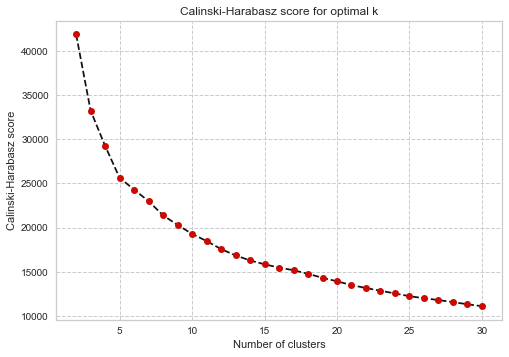

In [14]:
calinski_harabasz = []
for k in range_n_clusters:
    clusterer = cluster.KMeans(n_clusters=k, random_state=1)
    clusterer.fit(selected_components)
    cluster_labels = clusterer.labels_
    calinski_harabasz.append(calinski_harabasz_score(selected_components, cluster_labels))
    
plt.plot(range_n_clusters, calinski_harabasz, 'ko--', mfc='r')
plt.xlabel('Number of clusters')
plt.ylabel('Calinski-Harabasz score')
plt.title('Calinski-Harabasz score for optimal k')
plt.grid(linestyle='--')
plt.show()

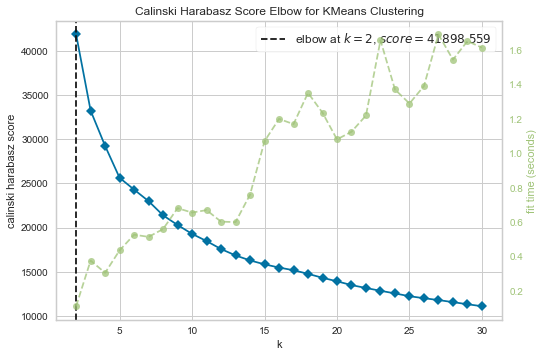

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [15]:
visualizer = KElbowVisualizer(cluster.KMeans(random_state=1), k=(2, 31), metric='calinski_harabasz', timings=True)
# Fit the data
visualizer.fit(selected_components)
# Finalize and render figure
visualizer.show()

# Davies-Bouldin score

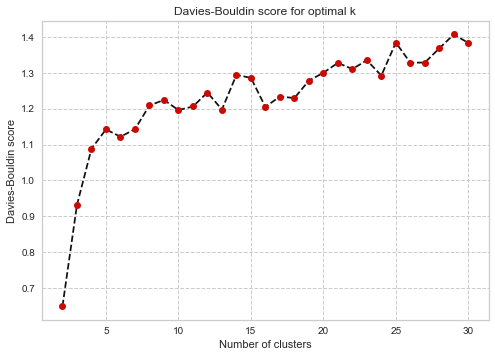

In [16]:
davies_bouldin = []
for k in range_n_clusters:
    clusterer = cluster.KMeans(n_clusters=k, random_state=1)
    clusterer.fit(selected_components)
    cluster_labels = clusterer.labels_
    davies_bouldin.append(davies_bouldin_score(selected_components, cluster_labels))
    
plt.plot(range_n_clusters, davies_bouldin, 'ko--', mfc='r')
plt.xlabel('Number of clusters')
plt.ylabel('Davies-Bouldin score')
plt.title('Davies-Bouldin score for optimal k')
plt.grid(linestyle='--')
plt.show()